In [3]:
import pandas as pd
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
COUNTRY = "Argentina"

In [5]:
QUERY = """
WITH most_frequent AS (
SELECT
o.user.id as user_id
, APPROX_TOP_COUNT(restaurant.name, 1)[OFFSET(0)].value as top_market

 FROM `peya-bi-tools-pro.il_core.fact_orders` o
 
 WHERE true
 AND registered_date BETWEEN "2020-09-01" AND "2021-09-30"
 AND business_type.business_type_id = 2
 AND o.order_status = "CONFIRMED"
GROUP BY 1
)

, min_date AS (
SELECT
o.user.id as user_id
, MIN(CASE WHEN business_type.business_type_id = 2 THEN o.registered_date END) as first_market_order_date
, MIN(CASE WHEN o.is_first_confirmed_order_user = 1 THEN o.registered_date END) as first_order_date 
 FROM `peya-bi-tools-pro.il_core.fact_orders` o
 
 WHERE true
 AND registered_date <= "2021-09-30"
 AND o.order_status = "CONFIRMED"
GROUP BY 1
)

SELECT

o.user.id as user_id
, u.country.country_name as country_name
, mf.top_market
, md.first_order_date
, DATE_TRUNC(md.first_order_date, MONTH) as first_order_month

, md.first_market_order_date
, DATE_TRUNC(md.first_market_order_date, MONTH) as first_market_order_month

, COUNT(DISTINCT o.order_id) as total_orders

, COUNT(DISTINCT DATE_TRUNC(o.registered_date, MONTH) ) as months_with_orders
, COUNT(DISTINCT CASE WHEN o.registered_date > md.first_market_order_date THEN o.order_id END) as total_orders_after_first_market
, COUNT(DISTINCT CASE WHEN o.registered_date > md.first_market_order_date THEN DATE_TRUNC(o.registered_date, MONTH) END) as months_with_orders_after_first_market

, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 THEN o.order_id END) as total_orders_markets
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND restaurant.name = mf.top_market THEN DATE_TRUNC(o.registered_date, MONTH) END) as months_most_freq
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND restaurant.name = mf.top_market THEN o.order_id END) as orders_most_freq
, SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND restaurant.name = mf.top_market THEN o.order_id END), COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 THEN o.order_id END)) AS pct_orders_most_freq
, SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND restaurant.name = mf.top_market THEN DATE_TRUNC(o.registered_date, MONTH) END), COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 THEN DATE_TRUNC(o.registered_date, MONTH) END)) as pct_months_most_freq


, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-09-01" THEN o.order_id END) as market_orders_sept
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-08-01" THEN o.order_id END) as market_orders_agosto
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-07-01" THEN o.order_id END) as market_orders_julio
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-06-01" THEN o.order_id END) as market_orders_junio
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-05-01" THEN o.order_id END) as market_orders_mayo
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-04-01" THEN o.order_id END) as market_orders_abril

, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-09-01" THEN o.order_id END) as orders_sept
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-08-01" THEN o.order_id END) as orders_agosto
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-07-01" THEN o.order_id END) as orders_julio
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-06-01" THEN o.order_id END) as orders_junio
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-05-01" THEN o.order_id END) as orders_mayo
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-04-01" THEN o.order_id END) as orders_abril

FROM `peya-bi-tools-pro.il_core.fact_orders` o
INNER JOIN most_frequent mf ON mf.user_id = o.user.id
LEFT JOIN `peya-bi-tools-pro.il_core.dim_user` u ON u.user_id = o.user.id
LEFT JOIN min_date md ON md.user_id = o.user.id
WHERE o.registered_date BETWEEN "2020-09-01" AND "2021-10-04"
AND o.order_status = "CONFIRMED"
GROUP BY 1, 2, 3, 4, 5, 6, 7
"""

df = pandas_gbq.read_gbq(QUERY, project_id="peya-growth-and-onboarding", dialect='standard')

df.to_csv("data/orders_by_user.csv", index=False)

Downloading: 100%|██████████| 2528356/2528356 [19:28<00:00, 2163.36rows/s]


### Preprocessing

In [10]:
df = pd.read_csv("data/orders_by_user.csv")
df = df[df.country_name == COUNTRY]
df.loc[(df.top_market.str.contains("PedidosYa Market")) &
       (~pd.isna(df.top_market)), "top_market"] = "PedidosYa Market"
       
df["has_1_order"] = df["total_orders_markets"] == 1
df["has_2_orders"] = df["total_orders_markets"] == 2
df["has_3_orders"] = df["total_orders_markets"] == 3
df["has_4_orders"] = df["total_orders_markets"] == 4
df["has_5_orders"] = df["total_orders_markets"] == 5
df["has_6_or_more_orders"] = df["total_orders_markets"] > 5

df["activo_agosto"] = df["market_orders_agosto"] > 0

df['first_market_order_month'] = pd.to_datetime(df['first_market_order_month'])
df['first_order_month'] = pd.to_datetime(df['first_order_month'])


df["is_acq"] = df['first_market_order_month'] == df['first_order_month']

df.loc[df['first_market_order_month'] < "2020-09-01", "first_market_order_month"] = "Before 2020-09"
df.loc[~(df['first_order_month'] >= "2020-09-01"), "first_order_month"] = "Before 2020-09"

df["quantity_orders"]  = df["total_orders_markets"]
df.loc[df["quantity_orders"] > 15, "quantity_orders"] = "+ 15"

In [11]:
df.head()

,user_id,country_name,top_market,first_order_date,first_order_month,first_market_order_date,first_market_order_month,total_orders,months_with_orders,total_orders_after_first_market,...,orders_abril,has_1_order,has_2_orders,has_3_orders,has_4_orders,has_5_orders,has_6_or_more_orders,activo_agosto,is_acq,quantity_orders
0,24044437,Argentina,PedidosYa Market,2020-08-22,Before 2020-09,2021-08-18,2021-08-01 00:00:00,18,9,0,...,0,True,False,False,False,False,False,True,False,1
8,17788492,Argentina,DIA - Grand Bourg,2020-01-11,Before 2020-09,2021-09-26,2021-09-01 00:00:00,22,8,0,...,4,True,False,False,False,False,False,False,False,1
13,37794536,Argentina,PedidosYa Market,2021-08-24,2021-08-01 00:00:00,2021-08-24,2021-08-01 00:00:00,1,1,0,...,0,True,False,False,False,False,False,True,True,1
17,26626484,Argentina,PedidosYa Market,2021-02-16,2021-02-01 00:00:00,2021-09-23,2021-09-01 00:00:00,8,5,0,...,1,True,False,False,False,False,False,False,False,1
26,33929698,Argentina,Barbas - San Rafael,2021-04-27,2021-04-01 00:00:00,2021-04-30,2021-04-01 00:00:00,2,1,0,...,2,True,False,False,False,False,False,False,True,1


### Quantity of orders by user group by first order month in Markets

In [12]:
df.groupby(['first_market_order_month']).agg( users=("user_id", "nunique"),
                                              is_acq=("is_acq", "sum"),
                                              activo_agosto=("activo_agosto", "sum"),
                                              orders_agosto=("market_orders_agosto", "sum"),
                                              has_1_orders=("has_1_order", "mean"),
                                              has_2_orders=("has_2_orders", "mean"),
                                              has_3_orders=("has_3_orders", "mean"),
                                              has_4_orders=("has_4_orders", "mean"),
                                              has_5_orders=("has_5_orders", "mean"),
                                              has_6_or_more_orders=("has_6_or_more_orders", "mean")
                                              )

,users,is_acq,activo_agosto,orders_agosto,has_1_orders,has_2_orders,has_3_orders,has_4_orders,has_5_orders,has_6_or_more_orders
first_market_order_month,,,,,,,,,,
2020-09-01 00:00:00,52170,6174,7630,18891,0.412287,0.174046,0.095016,0.061357,0.041001,0.216293
2020-10-01 00:00:00,56934,8137,8526,21016,0.435557,0.168792,0.091439,0.057646,0.040240,0.206327
2020-11-01 00:00:00,47742,6189,7136,17824,0.450002,0.171777,0.092330,0.056680,0.039064,0.190147
2020-12-01 00:00:00,41950,5148,6574,15962,0.443814,0.184744,0.094422,0.055971,0.037950,0.183099
2021-01-01 00:00:00,47186,6162,7355,17935,0.455834,0.178464,0.093608,0.059255,0.037130,0.175709
2021-02-01 00:00:00,44948,6330,7252,16779,0.476239,0.174735,0.091506,0.056399,0.036776,0.164345
2021-03-01 00:00:00,56069,9761,9304,21164,0.489968,0.178744,0.088908,0.055949,0.036045,0.150386
2021-04-01 00:00:00,62207,12524,10422,23642,0.512595,0.178420,0.084814,0.053901,0.035366,0.134904
2021-05-01 00:00:00,80585,18119,13847,28682,0.543811,0.177415,0.085574,0.050332,0.031557,0.111311


### Active users in August by total orders of user

In [13]:

df.groupby(["quantity_orders"]).agg(users=("user_id", "nunique"),
                                    activo_agosto=("activo_agosto", "sum"),
                                    orders_agosto=("market_orders_agosto", "sum")
                                    )

,users,activo_agosto,orders_agosto
quantity_orders,,,
1,564970,78012,78012
2,170940,32379,38836
3,82683,21236,27275
4,50125,15683,21340
5,33400,12348,17981
6,24069,10143,15891
7,18404,8625,14368
8,14621,7270,12883
9,11641,6180,11548


### Users with more than 5 Orders

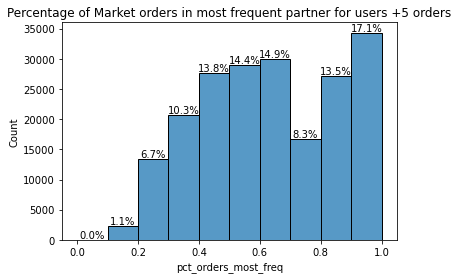

In [14]:
df_more_5 = df[df.total_orders_markets >= 5]
total = df_more_5.shape[0]

ax = plt.gca()

sns.histplot(data=df_more_5, x="pct_orders_most_freq",
             bins=[x / 10 for x in range(0, 11)], ax=ax)
             


for p in ax.patches:
      ax.text(p.get_x() + p.get_width()/2., p.get_height(),
                  '{:.1%}'.format(float(p.get_height()/total)),
              fontsize=10, color='black', ha='center', va='bottom')

ax.set_title("Percentage of Market orders in most frequent partner for users +5 orders")

plt.show()

In [15]:
df_gr = df_more_5.groupby(["top_market"])[["user_id"]].nunique().sort_values(by="user_id", ascending=False)

print(df_gr)

                                               user_id
top_market                                            
PedidosYa Market                                 94980
Carrefour - Market La Plata                       1533
Hiper Libertad Mendoza                            1117
La Anónima - Neuquén Centro                       1117
Supermercado Dar - Rioja                          1107
...                                                ...
Punto Copec - Iquique                                1
Punto Copec - Irarrazaval                            1
Longi Alimentos                                      1
Punto Copec - Lomas De Sa                            1
GoFriz Congelados Grido - 4938 - Tucuman XXXI        1

[2363 rows x 1 columns]
